# Figure 2: Pressure

- Panel (a): RTN Magnetic Field [nT]
- Panel (b): Pressure [nPa]
- Panel (c): Total/Expected Pressure [nPa]
- Panel (d): Electron/Proton plasma Beta 

In [2]:
import glob
import pyspedas
from pyspedas import time_string, time_double
from pytplot import tplot, get_data, cdf_to_tplot, store_data
import astrospice
import sunpy 
import sunpy.coordinates as scoords
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
from scipy import stats


import sys, os
import datetime
import numpy as np
sys.path.append(os.path.realpath(''))
import pandas as pd
import astropy.units as u
import matplotlib.pyplot as plt

import tools.utilities as utils
import tools.sigma as sigma
import tools.psp_funcs as psp_funcs
import tools.pfss_funcs as pfss_funcs
from tools.plotting import plot_pfss
from tools.settings import CsvDir, ImgDir, PlotDir, DataDir
import matplotlib.ticker as ticker


import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from datetime import timedelta

# for sc in ['psp','solar orbiter'] : kernels = astrospice.registry.get_kernels(sc,'predict') 

# REGIONS
loc_hcs = [61.8, 62.2]
loc_hcs1 = [357, 358.8]
ssw = [9, 19]
fsw = [42, 52]

# COLORS
scol, hcol, fcol, rcol = ['lavender', 'azure', 'lavenderblush', 'grey']
cc = ['lightpink', 'mediumspringgreen', 'peachpuff', 'powderblue', 'thistle', 'palegoldenrod']

# DIRECTORIES
RES_DIR = os.path.realpath('results')
FIG_DIR = os.path.realpath('figures')
EPS_DIR = os.path.realpath('eps_figures')
OBS_DIR = '/Users/tamarervin/products/csv_files/calcs/'
PlotDir = '/Users/tamarervin/mplstyle/'


# PLOT STYLING
plot_style = os.path.join(PlotDir, 'figure_series.mplstyle')
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.cal'] = 'Helvetica Neue LT Pro'
plt.rcParams.update({'font.size': 20})
plt.style.use(plot_style)
plt.rcParams['axes.linewidth'] = 5

enc='E15'


## Read in Data

In [3]:
# ### READ IN DATA ###
parker, parkerdownt, parkerdownl, pss, orbiter, orbiterdownl, orbiterdownt, oss, wind, winddownt, winddownl, wss = utils.read_data(RES_DIR)

### DEFINE REGIONS ###
lon_footpoints = parker.sslon
hhcs = np.logical_and(lon_footpoints >= loc_hcs[0], lon_footpoints <=loc_hcs[1])
hhcs1 = np.logical_and(lon_footpoints >= loc_hcs1[0], lon_footpoints <=loc_hcs1[1])
slow = np.logical_and(lon_footpoints >=ssw[0], lon_footpoints <=ssw[1])
fast = np.logical_and(lon_footpoints >=fsw[0], lon_footpoints <=fsw[1])

19-Dec-23 17:29:57: /Users/tamarervin/publications/e15_conjunction/tools/utilities.py:169: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()

19-Dec-23 17:29:57: /Users/tamarervin/publications/e15_conjunction/tools/utilities.py:169: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pss = parker.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()

19-Dec-23 17:30:05: /Users/tamarervin/publications/e15_conjunction/tools/utilities.py:178: FutureWarning: 'loffset' 

In [4]:
Rsun = (np.array(parker.rAU)*u.AU).to(u.Rsun)
parker['Ptotal'] = (parker.Pa + parker.Pp + parker.Pm + parker.Pe)/1e-9
parker['Pk'] = (parker.Pa + parker.Pp + parker.Pe)/1e-9
parker['Pap'] = (parker.Pa + parker.Pp)/1e-9

# FIT RADIAL PRESSURE

- except power-law index between -4 and -10/3
- since beta < 1 for period of interest, should be clsoer to -4

In [5]:
from scipy.optimize import curve_fit
from tabulate import tabulate

def linear_fit(x_data, y_data, initial_guess=(1.0)): #, parameter_bounds=([-4, 4], [-10/3, 8])):
    def model(x, m, b):
        return (10**b)*(x**m)

    # Fit the model
    params, covariance = curve_fit(model, x_data, y_data, p0=initial_guess)

    # Extract the fitted parameters
    m = params

    return m

initial_guess = (-3.31, 6.30)  

# Define the data and fits
data_names = ['Total', 'Magnetic', 'Kinetic', 'Alpha-Proton', 'Electron']
data_values = [parker.Ptotal, parker.Pm/1e-9, parker.Pk, parker.Pap, parker.Pe/1e-9]
fit_results = []

# Fit each data set and store the results
for data_name, data in zip(data_names, data_values):
    m = linear_fit(Rsun.value, data, initial_guess) #, parameter_bounds=([-5, 1], [-2, 16]))
    fit_results.append([data_name, m])

# Print the results as a table
print(tabulate(fit_results, headers=["Data", "Power-Law", "Coefficient"], tablefmt="pretty"))




19-Dec-23 17:30:07: /Users/tamarervin/anaconda3/envs/psp38/lib/python3.8/site-packages/tabulate/__init__.py:108: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or (len(row) >= 2 and row[1] == SEPARATING_LINE)



+--------------+-----------------------------+
|     Data     |          Power-Law          |
+--------------+-----------------------------+
|    Total     |  [-3.70834738  6.61868943]  |
|   Magnetic   |  [-3.60004393  6.3970063 ]  |
|   Kinetic    | [-15.61905089  19.4360409 ] |
| Alpha-Proton | [-11.08102035  14.12969667] |
|   Electron   |  [-2.05113895  3.53663355]  |
+--------------+-----------------------------+


In [6]:
from scipy.optimize import curve_fit
from tabulate import tabulate

def linear_fit(x_data, y_data, initial_guess=(1.0)): #, parameter_bounds=([-4, 4], [-10/3, 8])):
    def model(x, m, b):
        return (10**b)*(x**m)

    # Fit the model
    params, covariance = curve_fit(model, x_data, y_data, p0=initial_guess)

    # Extract the fitted parameters
    m = params

    return m

initial_guess = (-3.31, 6.61)  

# Define the data and fits
data_names = ['Total', 'Magnetic', 'Kinetic', 'Alpha-Proton', 'Electron']
data_values = [parker.Ptotal[slow], parker.Pm[slow]/1e-9, parker.Pk[slow], parker.Pap[slow], parker.Pe[slow]/1e-9]
fit_results = []

# Fit each data set and store the results
for data_name, data in zip(data_names, data_values):
    m = linear_fit(Rsun.value[slow], data, initial_guess) #, parameter_bounds=([-5, 1], [-2, 16]))
    fit_results.append([data_name, m])

# Print the results as a table
print('coefficient values for sub-sonic region')
print(tabulate(fit_results, headers=["Data", "Power-Law"], tablefmt="pretty"))




coefficient values for sub-sonic region
+--------------+---------------------------+
|     Data     |         Power-Law         |
+--------------+---------------------------+
|    Total     | [-3.37345878  6.14949675] |
|   Magnetic   | [-3.4693505   6.24008072] |
|   Kinetic    | [-1.93638915  3.16300158] |
| Alpha-Proton | [-4.96232003  6.59088894] |
|   Electron   |  [0.04451053 0.40569346]  |
+--------------+---------------------------+


In [7]:
from scipy.optimize import curve_fit
from tabulate import tabulate

def linear_fit(x_data, y_data, initial_guess=(1.0, 0.0)): #, parameter_bounds=([-4, 4], [-10/3, 8])):
    def model(x, b):
        return (10**b)*(x**(-10/3))

    # Fit the model
    params, covariance = curve_fit(model, x_data, y_data, p0=initial_guess)

    # Extract the fitted parameters
    b = params

    return b[0]

initial_guess = (5.96)  

# Define the data and fits
data_names = ['Total', 'Magnetic', 'Kinetic', 'Alpha-Proton', 'Electron']
data_values = [parker.Ptotal, parker.Pm/1e-9, parker.Pk, parker.Pap, parker.Pe/1e-9]
fit_results = []

# Fit each data set and store the results
for data_name, data in zip(data_names, data_values):
    b = linear_fit(Rsun.value, data, initial_guess) #, parameter_bounds=([-5, 1], [-2, 16]))
    fit_results.append([data_name, b])

# Print the results as a table
print('Coefficient Values for', '$R^{-10/3}$')
print(tabulate(fit_results, headers=["Data", "Coefficient"], tablefmt="pretty"))




Coefficient Values for $R^{-10/3}$
+--------------+-------------------+
|     Data     |    Coefficient    |
+--------------+-------------------+
|    Total     | 6.189332660108342 |
|   Magnetic   | 6.091582775225597 |
|   Kinetic    | 5.493705986466984 |
| Alpha-Proton | 5.320407599667191 |
|   Electron   | 5.01094452166901  |
+--------------+-------------------+


In [8]:
from scipy.optimize import curve_fit
from tabulate import tabulate

def linear_fit(x_data, y_data, initial_guess=(1.0, 0.0)): #, parameter_bounds=([-4, 4], [-10/3, 8])):
    def model(x, b):
        return (10**b)*(x**(-4))

    # Fit the model
    params, covariance = curve_fit(model, x_data, y_data, p0=initial_guess)

    # Extract the fitted parameters
    b = params

    return b[0]

initial_guess = (5.96)  

# Define the data and fits
data_names = ['Total', 'Magnetic', 'Kinetic', 'Alpha-Proton', 'Electron']
data_values = [parker.Ptotal, parker.Pm/1e-9, parker.Pk, parker.Pap, parker.Pe/1e-9]
fit_results = []

# Fit each data set and store the results
for data_name, data in zip(data_names, data_values):
    b = linear_fit(Rsun.value, data, initial_guess) #, parameter_bounds=([-5, 1], [-2, 16]))
    fit_results.append([data_name, b])

# Print the results as a table
print('Coefficient Values for $R^{-4}$')
print(tabulate(fit_results, headers=["Data", "Coefficient"], tablefmt="pretty"))




Coefficient Values for $R^{-4}$
+--------------+-------------------+
|     Data     |    Coefficient    |
+--------------+-------------------+
|    Total     | 6.951854201862705 |
|   Magnetic   | 6.853910065063214 |
|   Kinetic    |  6.2569962436577  |
| Alpha-Proton | 6.084740968521399 |
|   Electron   | 5.772099853826694 |
+--------------+-------------------+


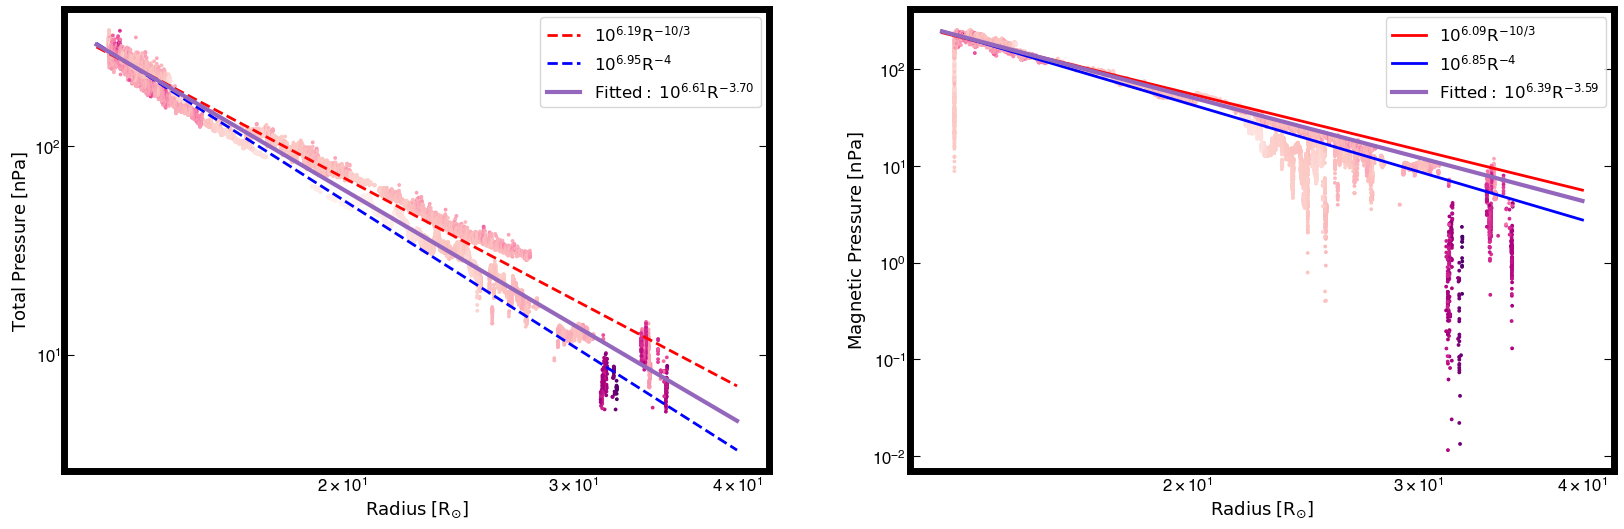

In [9]:

#### ------ RSun vs. Pressure ----- ####
fig, axs = plt.subplots(1, 2, figsize=[20,6], sharex='all')
x = np.linspace(13, 40)
i103 = (10**6.19)*x**(-10/3)
i4 = (10**6.95)*x**(-4)
fitt = (10**6.61)*(x**(-3.70))
### Total Pressure
ax = axs[0]
im = ax.scatter(Rsun.value, parker.Ptotal, c=parker.vr, cmap='RdPu', s=3)
ax.plot(x, i103, c='red', linewidth=2, linestyle='dashed', label=r'$\rm 10^{6.19} R^{-10/3}$')
ax.plot(x, i4, c='blue', linewidth=2, linestyle='dashed', label=r'$\rm 10^{6.95} R^{-4}$')
ax.plot(x, fitt, c='tab:purple', linewidth=3, label=r'$\rm Fitted: \;  10^{6.61} R^{-3.70}$')
ax.set(xlabel=r'$\rm Radius \; [R_{\odot}]$', ylabel=r'$\rm Total \; Pressure \; [nPa]$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

### Magnetic Pressure
i103 = (10**6.09)*x**(-10/3)
i4 = (10**6.85)*x**(-4)
fitb = (10**6.39)*(x**(-3.59))
ax = axs[1]
im = ax.scatter(Rsun.value, parker.Pm/1e-9, c=parker.vr, cmap='RdPu', s=3)
ax.set(xlabel=r'$\rm Radius \; [R_{\odot}]$', ylabel=r'$\rm Magnetic \; Pressure \; [nPa]$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(x, i103, c='red', linewidth=2, label=r'$\rm 10^{6.09} R^{-10/3}$')
ax.plot(x, i4, c='blue', linewidth=2, label=r'$\rm 10^{6.85} R^{-4}$')
ax.plot(x, fitb, c='tab:purple', linewidth=3, label=r'$\rm Fitted: \; 10^{6.39} R^{-3.59}$')
ax.legend()

# Magnetic Fluctuation Power

In [53]:
### GET HIGH RESOLUTION RTN DATA
files = glob.glob(os.path.join(os.path.realpath(os.path.join('psp_data', 'fields/l2/mag_rtn_4_per_cycle/2023')), "*"), recursive=True)
vars = cdf_to_tplot(files)
dt = get_data('psp_fld_l2_mag_RTN_4_Sa_per_Cyc')
date_obj = [datetime.datetime.strptime(time_string(d), '%Y-%m-%d %H:%M:%S.%f') for d in dt.times]

rd = {'Time': date_obj, 'Br': dt.y[:, 0], 'Bt': dt.y[:, 1], 'Bn': dt.y[:, 2]}
dfmag = pd.DataFrame(data=rd)

In [25]:
import numpy as np
from scipy.ndimage import convolve1d

def rolling_mean_field_direction(B, window_size):
    """
    Calculate the mean field direction within a rolling window.

    Parameters:
    - B: 2D array (n_samples x 3) - Magnetic field components in RTN coordinates.
    - window_size: int - Size of the rolling window.

    Returns:
    - mean_field_directions: 2D array (n_samples x 3) - Mean field directions.
    """
    kernel = np.ones((window_size,)) / window_size
    mean_field_directions = np.apply_along_axis(lambda x: x / np.linalg.norm(x), 1, convolve1d(B, kernel, axis=0, mode='constant'))
    return mean_field_directions

def transform_to_mean_field_aligned_coordinates(B, mean_field_directions):
    """
    Transform magnetic field data to the mean field-aligned coordinate system.

    Parameters:
    - B: 2D array (n_samples x 3) - Magnetic field components in RTN coordinates.
    - mean_field_directions: 2D array (n_samples x 3) - Mean field directions.

    Returns:
    - B_mean_field_aligned: 2D array (n_samples x 3) - Magnetic field components in mean field-aligned coordinates.
    """

    z = mean_field_directions
    y = -np.cross(z, B)
    y /= np.linalg.norm(y, axis=1)[:, None]
    x = np.cross(y, z)
    B_mean_field_aligned = np.column_stack((np.einsum('ij,ij->i', B, x),
                                            np.einsum('ij,ij->i', B, y),
                                            np.einsum('ij,ij->i', B, z)))
    return B_mean_field_aligned


In [54]:
### CALCULATE FLUCTUATIONS
num = 8
df = dfmag
B1, B2, B3 = df.Br, df.Bt, df.Bn
Bx_smo = sigma.smooth(B1, num)
By_smo = sigma.smooth(B2, num)
Bz_smo = sigma.smooth(B3, num)
delta_Bx = sigma.calculate_delta(B1, Bx_smo)
delta_By = sigma.calculate_delta(B2, By_smo)
delta_Bz = sigma.calculate_delta(B3, Bz_smo)


### ALIGN TO MEAN MAGNETIC FIELD
window_size = 24  
B = np.array([delta_Bx, delta_By, delta_Bz]).T
mean_field_directions = rolling_mean_field_direction(B, window_size)
B_mean_field_aligned = transform_to_mean_field_aligned_coordinates(B, mean_field_directions)
Bx, By, Bz = B_mean_field_aligned[:, 0], B_mean_field_aligned[:, 1], B_mean_field_aligned[:, 2]


In [59]:
### CALCULATE FLUCTUATION POWER
from numpy.fft import fftn, fftfreq

# calculate fourier transform of magnetic field components
Bx_fft = fftn(Bx)
By_fft = fftn(By) 
Bz_fft = fftn(Bz) 

# Compute Power Spectra
PSD_X = np.abs(Bx_fft)**2
PSD_Y = np.abs(By_fft)**2
PSD_Z = np.abs(Bz_fft)**2

# Calculate 1D Reduced Spectrum
Pxx = np.real(Bx_fft * np.conj(Bx_fft))
Pyy = np.real(By_fft * np.conj(By_fft))
Pzz = np.real(Bz_fft * np.conj(Bz_fft))

# Transverse component
df['P_perp'] = Pxx + Pyy

# Longitudinal component
df['P_parallel'] = Pzz

# anisotropy
df['P_ani'] = df.P_perp / df.P_parallel

In [63]:
df = df.set_index(df.Time)
sigma_bin = pd.Timedelta(minutes=10)
pss = df.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()
pss['Time'] = pss.index


19-Dec-23 17:50:26: /var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_8658/2936084486.py:3: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  pss = df.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()

19-Dec-23 17:50:26: /var/folders/by/lx780c7j7w58m_tkpc3q83kc0000gn/T/ipykernel_8658/2936084486.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pss = df.resample(sigma_bin, closed='left', label='left', loffset=sigma_bin / 2).mean()



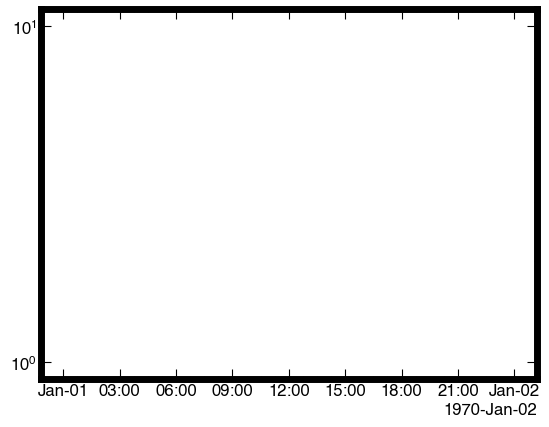

In [64]:
plt.plot(pss.Time, pss.P_ani)
plt.yscale('log')

# Create Figure

- RTN Magnetic Field
- Pressure
- Expected Pressure
- Beta

19-Dec-23 12:21:21: The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


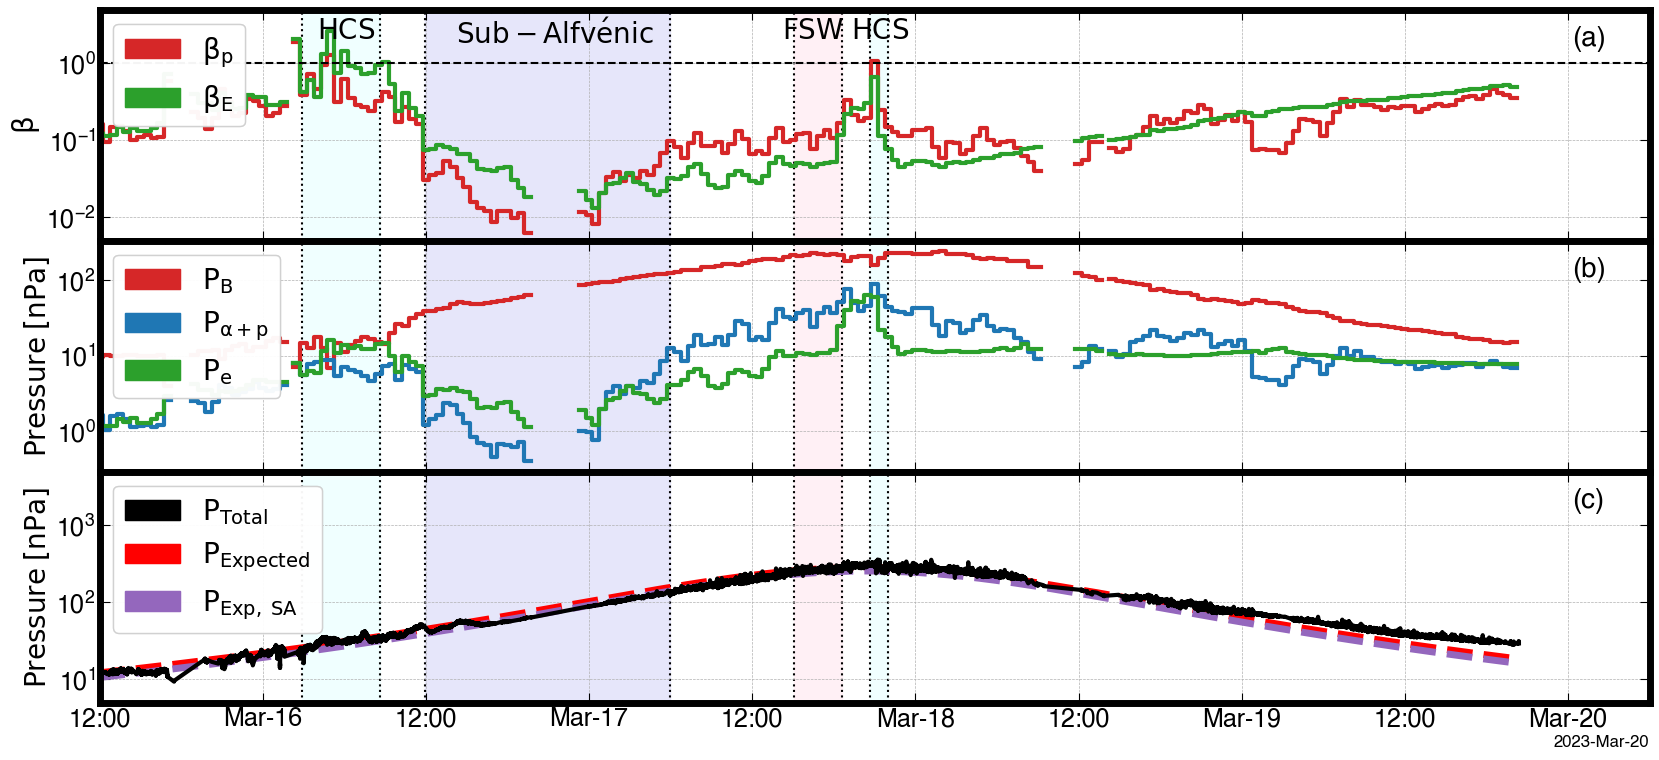

In [10]:
### PLOT SETUP
ss=1
fig = plt.figure(figsize=(20, 9))
grid = plt.GridSpec(3, 1, height_ratios=[1, 1, 1], wspace=0.05, hspace=0)

### LABELS
xlabel = r'$\rm Time$'
ylabels = [r'$\rm \beta$',
            r'$\rm Pressure \; [nPa]$', 
            r'$\rm Pressure \; [nPa]$'
            ]

### EXPECTED PRESSURE
Pexpt = (10**6.61)*(Rsun.value**(-3.70))
Pexptslow = (10**6.61)*(Rsun.value**(-3.74))

### DEFINE DATA, LABELS, COLORMAPS
rcol='grey'
cr, ct, cn, cmag = ['tab:red', 'tab:blue', 'tab:green', 'k']
lw=3
lwp=5

##### ---------- PANEL ONE: PLASMA BETA  ---------- ######
ax = plt.subplot(grid[0, 0])
ax.step(parkerdownt.Time, parkerdownt.beta, c=cr, linewidth=lw, label=r'$\rm \beta_p$')
ax.step(parkerdownt.Time, parkerdownt.betae, c=cn, linewidth=lw, label=r'$\rm \beta_E$')
ax.axhline(1, color='k', linestyle='dashed') ## plasma beta
ax.set_yscale('log')
ax.set_xticklabels([])
ax.set(ylim=(5e-3, 5e0), yticks=([1e-2, 1e-1, 1e0]))

### LEGEND ###
R_patch = mpatches.Patch(color=cr, label=r'$\rm \beta_p$')
N_patch = mpatches.Patch(color=cn, label=r'$\rm \beta_E$')
leg0 = ax.legend(handles=[R_patch, N_patch], loc='upper left', fontsize=20)
ax.add_artist(leg0)
# ax.set_title(r'$\rm Full \; Encounter$', fontsize=22)

##### ---------- PANEL TWO: PRESSURES  ---------- ######
ax = plt.subplot(grid[1, 0])
ax.step(parkerdownt.Time, parkerdownt.Pm/1e-9, c=cr, linewidth=lw, label=r'$\rm P_{B}$')
ax.step(parkerdownt.Time, (parkerdownt.Pa + parkerdownt.Pp)/1e-9, c=ct, linewidth=lw, label=r'$\rm P_{\alpha + p}$') #, s=ss)
ax.step(parkerdownt.Time, (parkerdownt.Pe)/1e-9, c=cn, linewidth=lw, label=r'$\rm P_{e}$') #, s=ss)
ax.set_yscale('log')
ax.set_xticklabels([])

### LEGEND ###
R_patch = mpatches.Patch(color=cr, label=r'$\rm P_{B}$')
T_patch = mpatches.Patch(color=ct, label=r'$\rm P_{\alpha + p}$')
N_patch = mpatches.Patch(color=cn, label=r'$\rm P_{e}$')
leg0 = ax.legend(handles=[R_patch, T_patch, N_patch], loc='upper left', fontsize=20)
ax.add_artist(leg0)


##### ---------- PANEL THREE: TOTAL PRESSURE  ---------- ######
ax = plt.subplot(grid[2, 0])
ax.plot(parker.Time, parker.Ptotal, c=cmag, linewidth=lw, label=r'$\rm P_{Total}$', zorder=3)
ax.plot(parker.Time, Pexpt, c='red', linestyle='dashed', linewidth=lwp, label=r'$\rm P_{Expected}$')
ax.plot(parker.Time, Pexptslow, c='tab:purple', linestyle='dashed', linewidth=lwp, label=r'$\rm P_{Expected, \; Sub-Alfv\'enic}$')
ax.set_yscale('log')
ax.set(ylim=(5e0, 5e3), yticks=([1e1, 1e2, 1e3]))

### LEGEND ###
M_patch = mpatches.Patch(color=cmag, label=r'$\rm P_{Total}$')
T_patch = mpatches.Patch(color='red', label=r'$\rm P_{Expected}$')
N_patch = mpatches.Patch(color='tab:purple', label=r'$\rm P_{Exp, \; SA}$')
leg0 = ax.legend(handles=[M_patch, T_patch, N_patch], loc='upper left', fontsize=20)
ax.add_artist(leg0)


##### ---------- FULL DATA  ---------- ######
panel_labels = ['(a)', '(b)', '(c)', '(d)']
for i, ax in enumerate([plt.subplot(grid[0, 0]), plt.subplot(grid[1, 0]), plt.subplot(grid[2, 0])]): #, plt.subplot(grid[3, 0])]):
    ### ADD Y-LABEL
    ax.set_ylabel(ylabel=ylabels[i], fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18) 
    
    ### ADD X-LIMITS
    ax.set_xlim(pd.Timestamp('2023-03-15 12:00:00'), pd.Timestamp('2023-03-20 06:00:00'))

    ### ADD THE GRID
    ax.grid(True, linestyle='--', linewidth=0.5)

    ### ADD REGIONS
    regions = [
        (parker[hhcs].Time.iloc[0], parker[hhcs].Time.iloc[-1], hcol),
        (parker[hhcs1].Time.iloc[0], parker[hhcs1].Time.iloc[-1], hcol),
        (parker[slow].Time.iloc[0], parker[slow].Time.iloc[-1], scol),
        (parker[fast].Time.iloc[0], parker[fast].Time.iloc[-1], fcol)
    ]

    lines = [
        parker[hhcs].Time.iloc[0],
        parker[hhcs].Time.iloc[-1],
        parker[hhcs1].Time.iloc[0],
        parker[hhcs1].Time.iloc[-1],
        parker[slow].Time.iloc[0],
        parker[slow].Time.iloc[-1],
        parker[fast].Time.iloc[0],
        parker[fast].Time.iloc[-1]
    ]

    ### PLOT LINES AND REGIONS
    for line in lines:
        ax.axvline(line, color='k', linestyle='dotted', zorder=-2)

    for region in regions:
        ax.axvspan(region[0], region[1], color=region[2], zorder=-3)

    ### ADD PANEL LABELS
    ax.text(0.95, 0.93, panel_labels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

# ##### ---------- PANEL FOUR: PLASMA BETA -- ZOOM  ---------- ######
# ax = plt.subplot(grid[0, 1])
# ax.step(parkerdownt.Time, parkerdownt.beta, c=cr, linewidth=lw, label=r'$\rm \beta_p$')
# ax.step(parkerdownt.Time, parkerdownt.betae, c=cn, linewidth=lw, label=r'$\rm \beta_E$')
# ax.axhline(1, color='k', linestyle='dashed') ## plasma beta
# ax.set_yscale('log')
# ax.set(ylim=(5e-3, 5e0), yticks=([1e-2, 1e-1, 1e0]))
# ax.set_xticklabels([])
# ax.set_title(r'$\rm Sub-Alfv\'enic \; Period$', fontsize=22)

# ##### ---------- PANEL FIVE: PRESSURES -- ZOOM  ---------- ######
# ax = plt.subplot(grid[1, 1])
# ax.step(parkerdownt.Time, parkerdownt.Pm/1e-9, c=cr, linewidth=lw, label=r'$\rm P_{B}$')
# ax.step(parkerdownt.Time, (parkerdownt.Pa + parkerdownt.Pp)/1e-9, c=ct, linewidth=lw, label=r'$\rm P_{\alpha + p}$')
# ax.step(parkerdownt.Time, (parkerdownt.Pe)/1e-9, c=cn, linewidth=lw, label=r'$\rm P_{e}$')
# ax.set_yscale('log')
# ax.set_xticklabels([])
# # ax.sharey(plt.subplot(grid[1, 0]))

# ##### ---------- PANEL SIX: TOTAL PRESSURE -- ZOOM  ---------- ######
# ax = plt.subplot(grid[2, 1])
# ax.plot(parker.Time, parker.Ptotal, c=cmag, linewidth=lw, label=r'$\rm P_{Total}$', zorder=10)
# ax.plot(parker.Time, Pexptslow, c='tab:purple', linestyle='dashed', linewidth=lwp, label=r'$\rm P_{Expected}$')
# ax.set_yscale('log')
# ax.set(ylim=(5e0, 5e3), yticks=([1e1, 1e2, 1e3]))

# panel_labels = ['(d)', '(e)', '(f)', '(g)', '(h)']
# for i, ax in enumerate([plt.subplot(grid[0, 1]), plt.subplot(grid[1, 1]), plt.subplot(grid[2, 1])]): #, plt.subplot(grid[3, 1])]):
#     ### ADD THE GRID
#     ax.grid(True, linestyle='--', linewidth=0.5)
#     ax.xaxis.set_minor_locator(ticker.NullLocator())

#     ### ADD X-LIMITS
#     ax.tick_params(axis='both', which='major', labelsize=18) 
#     ax.set_xlim(parker[slow].Time.iloc[0], parker[slow].Time.iloc[-1])
#     ax.set_xticks([pd.Timestamp('2023-03-16 12:00:00'), pd.Timestamp('2023-03-16 16:00:00'), pd.Timestamp('2023-03-16 20:00:00'),
#                    pd.Timestamp('2023-03-17 00:00:00'), pd.Timestamp('2023-03-17 04:00:00')])
    
#     ### REMOVE TICK LABELS
#     ax.set_yticklabels([])

#     ### ADD PANEL LABELS
#     ax.text(0.93, 0.93, panel_labels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

##### ---------- LABEL REGIONS OF INTEREST ---------- ######
ax = plt.subplot(grid[0, 0])
ax.text(0.14, 0.96, r'$\rm HCS$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.text(0.23, 0.96, r'$\rm Sub-Alfv\'enic$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.text(0.44, 0.96, r'$\rm FSW$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.text(0.485, 0.96, r'$\rm HCS$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

### SAVE FIGURE ###
plt.savefig(os.path.realpath(os.path.join(FIG_DIR, 'fig2.png')), bbox_inches='tight')
plt.savefig(os.path.realpath(os.path.join(EPS_DIR, 'fig2.eps')), bbox_inches='tight')

# Full Data

Text(0.485, 0.96, '$\\rm HCS$')

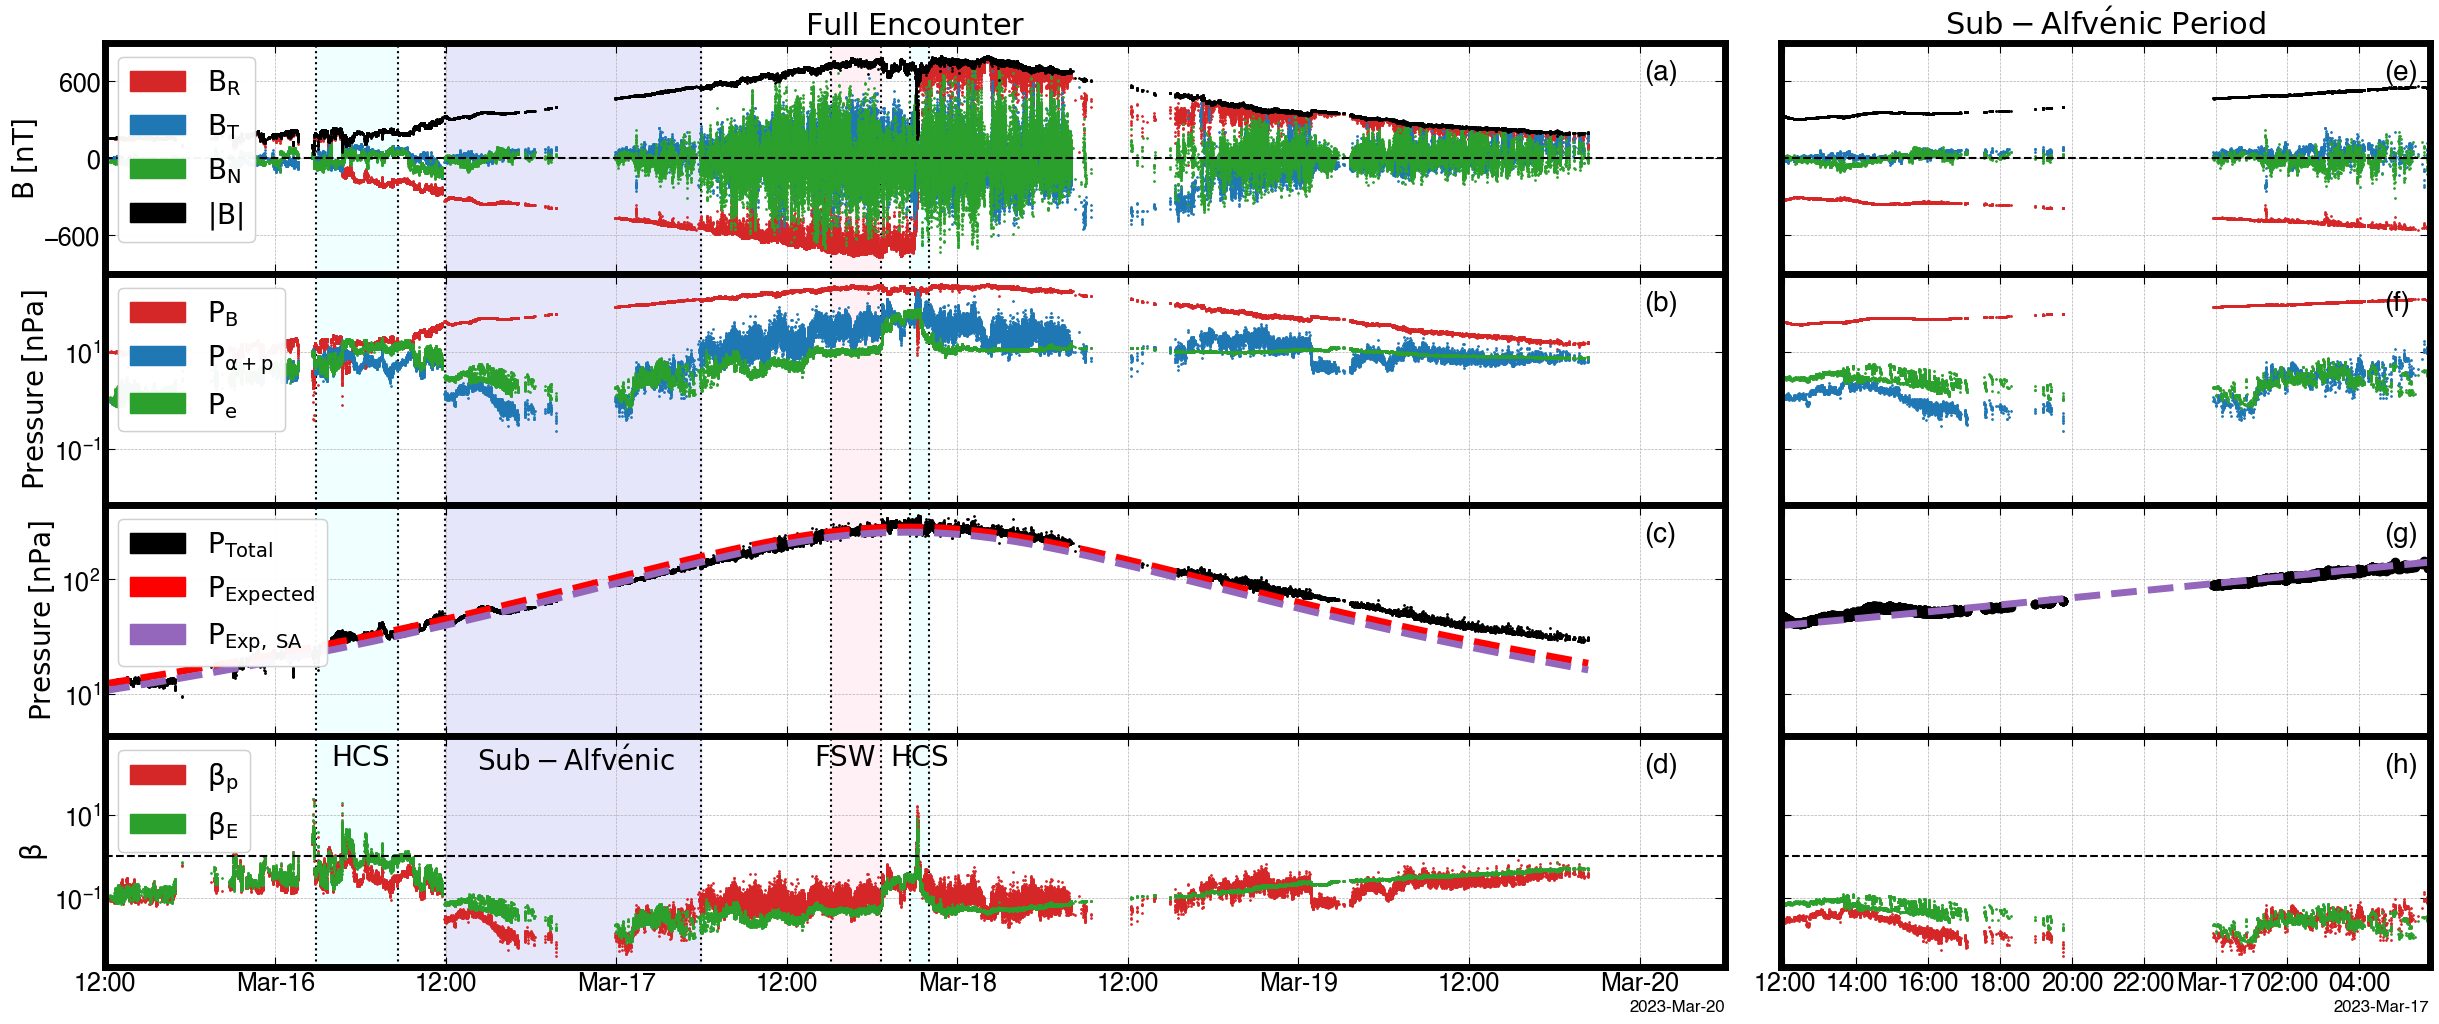

In [ ]:
### PLOT SETUP
ss=1
fig = plt.figure(figsize=(30, 12))
grid = plt.GridSpec(4, 2, width_ratios=[5, 2], height_ratios=[1, 1, 1, 1], wspace=0.05, hspace=0)

### LABELS
xlabel = r'$\rm Time$'
ylabels = [r'$\rm B \; [nT]$',
            r'$\rm Pressure \; [nPa]$', 
            r'$\rm Pressure \; [nPa]$',
            r'$\rm \beta$']

### EXPECTED PRESSURE
Pexpt = (10**6.61)*(Rsun.value**(-3.70))
Pexptslow = (10**6.61)*(Rsun.value**(-3.74))

### DEFINE DATA, LABELS, COLORMAPS
rcol='grey'
cr, ct, cn, cmag = ['tab:red', 'tab:blue', 'tab:green', 'k']
lw=1
lwp=5

##### ---------- PANEL ONE: RTN MAGNETIC FIELD  ---------- ######
ax = plt.subplot(grid[0, 0])
ax.scatter(parker.Time, parker.Br, c=cr, linewidth=lw, label=r'$\rm B_R$', s=ss)
ax.scatter(parker.Time, parker.Bt, c=ct, linewidth=lw, label=r'$\rm B_T$', s=ss)
ax.scatter(parker.Time, parker.Bn, c=cn, linewidth=lw, label=r'$\rm B_N$', s=ss)
ax.scatter(parker.Time, parker.B, c=cmag, linewidth=lw, label=r'$\rm |B|$', s=ss)
ax.set(ylim=(-900, 900), yticks=np.arange(-600, 601, step=600)) ## magnetic field
ax.axhline(0, color='k', linestyle='dashed') ## radial magnetic field
ax.set_title(r'$\rm Full \; Encounter$', fontsize=22)
ax.set_xticklabels([])

### LEGEND ###
R_patch = mpatches.Patch(color=cr, label=r'$\rm B_R$')
T_patch = mpatches.Patch(color=ct, label=r'$\rm B_T$')
N_patch = mpatches.Patch(color=cn, label=r'$\rm B_N$')
M_patch = mpatches.Patch(color=cmag, label=r'$\rm |B|$')
leg0 = ax.legend(handles=[R_patch, T_patch, N_patch, M_patch], loc='upper left', fontsize=20)
ax.add_artist(leg0)

##### ---------- PANEL TWO: PRESSURES  ---------- ######
ax = plt.subplot(grid[1, 0])
ax.scatter(parker.Time, parker.Pm/1e-9, c=cr, linewidth=lw, label=r'$\rm P_{B}$', s=ss)
ax.scatter(parker.Time, (parker.Pa + parker.Pp)/1e-9, c=ct, linewidth=lw, label=r'$\rm P_{\alpha + p}$', s=ss)
ax.scatter(parker.Time, (parker.Pe)/1e-9, c=cn, linewidth=lw, label=r'$\rm P_{e}$', s=ss)
ax.set_yscale('log')
ax.set_xticklabels([])

### LEGEND ###
R_patch = mpatches.Patch(color=cr, label=r'$\rm P_{B}$')
T_patch = mpatches.Patch(color=ct, label=r'$\rm P_{\alpha + p}$')
N_patch = mpatches.Patch(color=cn, label=r'$\rm P_{e}$')
leg0 = ax.legend(handles=[R_patch, T_patch, N_patch], loc='upper left', fontsize=20)
ax.add_artist(leg0)

##### ---------- PANEL THREE: TOTAL PRESSURE  ---------- ######
ax = plt.subplot(grid[2, 0])
ax.scatter(parker.Time, parker.Ptotal, c=cmag, linewidth=lw, label=r'$\rm P_{Total}$', s=ss)
ax.plot(parker.Time, Pexpt, c='red', linestyle='dashed', linewidth=lwp, label=r'$\rm P_{Expected}$')
ax.plot(parker.Time, Pexptslow, c='tab:purple', linestyle='dashed', linewidth=lwp, label=r'$\rm P_{Expected, \; Sub-Alfv\'enic}$')

ax.set_yscale('log')
ax.set_xticklabels([])

### LEGEND ###
M_patch = mpatches.Patch(color=cmag, label=r'$\rm P_{Total}$')
T_patch = mpatches.Patch(color='red', label=r'$\rm P_{Expected}$')
N_patch = mpatches.Patch(color='tab:purple', label=r'$\rm P_{Exp, \; SA}$')
leg0 = ax.legend(handles=[M_patch, T_patch, N_patch], loc='upper left', fontsize=20)
ax.add_artist(leg0)

##### ---------- PANEL FOUR: PLASMA BETA  ---------- ######
ax = plt.subplot(grid[3, 0])
ax.scatter(parker.Time, parker.beta, c=cr, linewidth=lw, label=r'$\rm \beta_p$', s=ss)
ax.scatter(parker.Time, parker.betae, c=cn, linewidth=lw, label=r'$\rm \beta_E$', s=ss)
ax.axhline(1, color='k', linestyle='dashed') ## plasma beta
ax.set_yscale('log')

### LEGEND ###
R_patch = mpatches.Patch(color=cr, label=r'$\rm \beta_p$')
N_patch = mpatches.Patch(color=cn, label=r'$\rm \beta_E$')
leg0 = ax.legend(handles=[R_patch, N_patch], loc='upper left', fontsize=20)
ax.add_artist(leg0)


##### ---------- FULL DATA  ---------- ######
panel_labels = ['(a)', '(b)', '(c)', '(d)']
for i, ax in enumerate([plt.subplot(grid[0, 0]), plt.subplot(grid[1, 0]), plt.subplot(grid[2, 0]), plt.subplot(grid[3, 0])]):
    ### ADD Y-LABEL
    ax.set_ylabel(ylabel=ylabels[i], fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18) 
    
    ### ADD X-LIMITS
    ax.set_xlim(pd.Timestamp('2023-03-15 12:00:00'), pd.Timestamp('2023-03-20 06:00:00'))

    ### ADD THE GRID
    ax.grid(True, linestyle='--', linewidth=0.5)

    ### ADD REGIONS
    regions = [
        (parker[hhcs].Time.iloc[0], parker[hhcs].Time.iloc[-1], hcol),
        (parker[hhcs1].Time.iloc[0], parker[hhcs1].Time.iloc[-1], hcol),
        (parker[slow].Time.iloc[0], parker[slow].Time.iloc[-1], scol),
        (parker[fast].Time.iloc[0], parker[fast].Time.iloc[-1], fcol)
    ]

    lines = [
        parker[hhcs].Time.iloc[0],
        parker[hhcs].Time.iloc[-1],
        parker[hhcs1].Time.iloc[0],
        parker[hhcs1].Time.iloc[-1],
        parker[slow].Time.iloc[0],
        parker[slow].Time.iloc[-1],
        parker[fast].Time.iloc[0],
        parker[fast].Time.iloc[-1]
    ]

    ### PLOT LINES AND REGIONS
    for line in lines:
        ax.axvline(line, color='k', linestyle='dotted', zorder=-2)

    for region in regions:
        ax.axvspan(region[0], region[1], color=region[2], zorder=-3)

    ### ADD PANEL LABELS
    ax.text(0.95, 0.93, panel_labels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')


##### ---------- PANEL FIVE: RTN FIELD -- ZOOM  ---------- ######
ax = plt.subplot(grid[0, 1])
ax.scatter(parker.Time, parker.Br, c=cr, linewidth=lw, label=r'$\rm B_R$', s=ss)
ax.scatter(parker.Time, parker.Bt, c=ct, linewidth=lw, label=r'$\rm B_T$', s=ss)
ax.scatter(parker.Time, parker.Bn, c=cn, linewidth=lw, label=r'$\rm B_N$', s=ss)
ax.scatter(parker.Time, parker.B, c=cmag, linewidth=lw, label=r'$\rm |B|$', s=ss)
ax.set(ylim=(-900, 900), yticks=np.arange(-600, 601, step=600)) ## magnetic field
ax.axhline(0, color='k', linestyle='dashed') ## radial magnetic field
ax.set_xticklabels([])
ax.set_title(r'$\rm Sub-Alfv\'enic \; Period$', fontsize=22)

##### ---------- PANEL SIX: PRESSURES -- ZOOM  ---------- ######
ax = plt.subplot(grid[1, 1])
ax.scatter(parker.Time, parker.Pm/1e-9, c=cr, linewidth=lw, label=r'$\rm P_{B}$', s=ss)
ax.scatter(parker.Time, parker.Pap, c=ct, linewidth=lw, label=r'$\rm P_{\alpha + p}$', s=ss)
ax.scatter(parker.Time, (parker.Pe)/1e-9, c=cn, linewidth=lw, label=r'$\rm P_{e}$', s=ss)
ax.set_yscale('log')
ax.set_xticklabels([])

##### ---------- PANEL SEVEN: TOTAL PRESSURE -- ZOOM  ---------- ######
ax = plt.subplot(grid[2, 1])
ax.scatter(parker.Time, parker.Ptotal, c=cmag, linewidth=lw, label=r'$\rm P_{Total}$')
ax.plot(parker.Time, Pexptslow, c='tab:purple', linestyle='dashed', linewidth=lwp, label=r'$\rm P_{Expected}$')
ax.set_yscale('log')
ax.set_xticklabels([])

##### ---------- PANEL EIGHT: PLASMA BETA -- ZOOM  ---------- ######
ax = plt.subplot(grid[3, 1])
ax.scatter(parker.Time, parker.beta, c=cr, linewidth=lw, label=r'$\rm \beta_p$', s=ss)
ax.scatter(parker.Time, parker.betae, c=cn, linewidth=lw, label=r'$\rm \beta_E$', s=ss)
ax.axhline(1, color='k', linestyle='dashed') ## plasma beta
ax.set_yscale('log')

panel_labels = ['(e)', '(f)', '(g)', '(h)']
for i, ax in enumerate([plt.subplot(grid[0, 1]), plt.subplot(grid[1, 1]), plt.subplot(grid[2, 1]), plt.subplot(grid[3, 1])]):
    ### ADD THE GRID
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.xaxis.set_minor_locator(ticker.NullLocator())

    ### ADD X-LIMITS
    ax.tick_params(axis='both', which='major', labelsize=18) 
    ax.set_xlim(parker[slow].Time.iloc[0], parker[slow].Time.iloc[-1])

    ### REMOVE TICK LABELS
    ax.set_yticklabels([])

    ### ADD PANEL LABELS
    ax.text(0.93, 0.93, panel_labels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

##### ---------- LABEL REGIONS OF INTEREST ---------- ######
ax = plt.subplot(grid[3, 0])
ax.text(0.14, 0.96, r'$\rm HCS$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.text(0.23, 0.96, r'$\rm Sub-Alfv\'enic$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.text(0.438, 0.96, r'$\rm FSW$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
ax.text(0.485, 0.96, r'$\rm HCS$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

### SAVE FIGURE ###
# plt.savefig(os.path.realpath(os.path.join(FIG_DIR, 'fig2.png')), bbox_inches='tight')
# plt.savefig(os.path.realpath(os.path.join(EPS_DIR, 'fig2.eps')), bbox_inches='tight')

## Original Figure

In [ ]:
# ### PLOT SETUP
# fig = plt.figure(figsize=(30, 12))
# grid = plt.GridSpec(4, 2, width_ratios=[5, 2], height_ratios=[1, 1, 1, 1], wspace=0.05, hspace=0)

# ### LABELS
# xlabel = r'$\rm Time$'
# ylabels = [r'$\rm B \; [nT]$',
#             r'$\rm Pressure \; [nPa]$', 
#             r'$\rm Pressure \; [nPa]$',
#             r'$\rm \beta$']

# ### EXPECTED PRESSURE
# Pexpt = (10**6.61)*(Rsun.value**(-3.70))
# Pexptslow = (10**6.61)*(Rsun.value**(-3.74))

# ### DEFINE DATA, LABELS, COLORMAPS
# rcol='grey'
# cr, ct, cn, cmag = ['blue', 'green', 'red', 'k']
# cr, ct, cn, cmag = ['tab:blue', 'tab:green', 'tab:purple', 'k']
# lw=1
# lwp=5

# ##### ---------- PANEL ONE: RTN MAGNETIC FIELD  ---------- ######
# ax = plt.subplot(grid[0, 0])
# ax.plot(parker.Time, parker.Br, c=cr, linewidth=lw, label=r'$\rm B_R$')
# ax.plot(parker.Time, parker.Bt, c=ct, linewidth=lw, label=r'$\rm B_T$')
# ax.plot(parker.Time, parker.Bn, c=cn, linewidth=lw, label=r'$\rm B_N$')
# ax.plot(parker.Time, parker.B, c=cmag, linewidth=lw, label=r'$\rm |B|$')
# ax.set(ylim=(-900, 900), yticks=np.arange(-600, 601, step=600)) ## magnetic field
# ax.axhline(0, color='k', linestyle='dashed') ## radial magnetic field
# ax.legend(loc='upper left', fontsize=20)
# ax.set_title(r'$\rm Full \; Encounter$', fontsize=22)
# ax.set_xticklabels([])

# ##### ---------- PANEL TWO: PRESSURES  ---------- ######
# ax = plt.subplot(grid[1, 0])
# ax.plot(parker.Time, parker.Pm/1e-9, c=cr, linewidth=lw, label=r'$\rm P_{B}$')
# ax.plot(parker.Time, (parker.Pa + parker.Pp)/1e-9, c=ct, linewidth=lw, label=r'$\rm P_{\alpha + p}$')
# ax.plot(parker.Time, (parker.Pe)/1e-9, c=cn, linewidth=lw, label=r'$\rm P_{e}$')
# ax.set_yscale('log')
# ax.legend(loc='upper left', fontsize=20)
# ax.set_xticklabels([])

# ##### ---------- PANEL THREE: TOTAL PRESSURE  ---------- ######
# ax = plt.subplot(grid[2, 0])
# ax.plot(parker.Time, parker.Ptotal, c=cmag, linewidth=lw, label=r'$\rm P_{Total}$')
# ax.plot(parker.Time, Pexpt, c='red', linestyle='dashed', linewidth=lwp, label=r'$\rm P_{Expected}$')
# ax.plot(parker.Time, Pexptslow, c='tab:purple', linestyle='dashed', linewidth=lwp, label=r'$\rm P_{Expected, \; Sub-Alfv\'enic}$')

# ax.set_yscale('log')
# ax.legend(loc='upper left', fontsize=20)
# ax.set_xticklabels([])

# ##### ---------- PANEL FOUR: PLASMA BETA  ---------- ######
# ax = plt.subplot(grid[3, 0])
# ax.plot(parker.Time, parker.beta, c=cr, linewidth=lw, label=r'$\rm \beta_p$')
# ax.plot(parker.Time, parker.betae, c=cn, linewidth=lw, label=r'$\rm \beta_E$')
# ax.axhline(1, color='k', linestyle='dashed') ## plasma beta
# ax.legend(loc='upper left', fontsize=20)
# ax.set_yscale('log')

# ##### ---------- FULL DATA  ---------- ######
# panel_labels = ['(a)', '(b)', '(c)', '(d)']
# for i, ax in enumerate([plt.subplot(grid[0, 0]), plt.subplot(grid[1, 0]), plt.subplot(grid[2, 0]), plt.subplot(grid[3, 0])]):
#     ### ADD Y-LABEL
#     ax.set_ylabel(ylabel=ylabels[i], fontsize=20)
#     ax.tick_params(axis='both', which='major', labelsize=18) 
    
#     ### ADD X-LIMITS
#     ax.set_xlim(pd.Timestamp('2023-03-15 12:00:00'), pd.Timestamp('2023-03-20 06:00:00'))

#     ### ADD THE GRID
#     ax.grid(True, linestyle='--', linewidth=0.5)

#     ### ADD REGIONS
#     regions = [
#         (parker[hhcs].Time.iloc[0], parker[hhcs].Time.iloc[-1], hcol),
#         (parker[hhcs1].Time.iloc[0], parker[hhcs1].Time.iloc[-1], hcol),
#         (parker[slow].Time.iloc[0], parker[slow].Time.iloc[-1], scol),
#         (parker[fast].Time.iloc[0], parker[fast].Time.iloc[-1], fcol)
#     ]

#     lines = [
#         parker[hhcs].Time.iloc[0],
#         parker[hhcs].Time.iloc[-1],
#         parker[hhcs1].Time.iloc[0],
#         parker[hhcs1].Time.iloc[-1],
#         parker[slow].Time.iloc[0],
#         parker[slow].Time.iloc[-1],
#         parker[fast].Time.iloc[0],
#         parker[fast].Time.iloc[-1]
#     ]

#     ### PLOT LINES AND REGIONS
#     for line in lines:
#         ax.axvline(line, color='k', linestyle='dotted', zorder=-2)

#     for region in regions:
#         ax.axvspan(region[0], region[1], color=region[2], zorder=-3)

#     ### ADD PANEL LABELS
#     ax.text(0.95, 0.93, panel_labels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')


# ##### ---------- PANEL FIVE: RTN FIELD -- ZOOM  ---------- ######
# ax = plt.subplot(grid[0, 1])
# ax.plot(parker.Time, parker.Br, c=cr, linewidth=lw, label=r'$\rm B_R$')
# ax.plot(parker.Time, parker.Bt, c=ct, linewidth=lw, label=r'$\rm B_T$')
# ax.plot(parker.Time, parker.Bn, c=cn, linewidth=lw, label=r'$\rm B_N$')
# ax.plot(parker.Time, parker.B, c=cmag, linewidth=lw, label=r'$\rm |B|$')
# ax.set(ylim=(-900, 900), yticks=np.arange(-600, 601, step=600)) ## magnetic field
# ax.axhline(0, color='k', linestyle='dashed') ## radial magnetic field
# ax.set_xticklabels([])
# ax.set_title(r'$\rm Sub-Alfv\'enic \; Period$', fontsize=22)

# ##### ---------- PANEL SIX: PRESSURES -- ZOOM  ---------- ######
# ax = plt.subplot(grid[1, 1])
# ax.plot(parker.Time, parker.Pm/1e-9, c=cr, linewidth=lw, label=r'$\rm P_{B}$')
# ax.plot(parker.Time, parker.Pap, c=ct, linewidth=lw, label=r'$\rm P_{\alpha + p}$')
# ax.plot(parker.Time, (parker.Pe)/1e-9, c=cn, linewidth=lw, label=r'$\rm P_{e}$')
# ax.set_yscale('log')
# ax.set_xticklabels([])

# ##### ---------- PANEL SEVEN: TOTAL PRESSURE -- ZOOM  ---------- ######
# ax = plt.subplot(grid[2, 1])
# ax.plot(parker.Time, parker.Ptotal, c=cmag, linewidth=lw, label=r'$\rm P_{Total}$')
# ax.plot(parker.Time, Pexptslow, c='tab:purple', linestyle='dashed', linewidth=lwp, label=r'$\rm P_{Expected}$')
# ax.set_yscale('log')
# ax.set_xticklabels([])

# ##### ---------- PANEL EIGHT: PLASMA BETA -- ZOOM  ---------- ######
# ax = plt.subplot(grid[3, 1])
# ax.plot(parker.Time, parker.beta, c=cr, linewidth=lw, label=r'$\rm \beta_p$')
# ax.plot(parker.Time, parker.betae, c=cn, linewidth=lw, label=r'$\rm \beta_E$')
# ax.axhline(1, color='k', linestyle='dashed') ## plasma beta
# ax.set_yscale('log')

# panel_labels = ['(e)', '(f)', '(g)', '(h)']
# for i, ax in enumerate([plt.subplot(grid[0, 1]), plt.subplot(grid[1, 1]), plt.subplot(grid[2, 1]), plt.subplot(grid[3, 1])]):
#     ### ADD THE GRID
#     ax.grid(True, linestyle='--', linewidth=0.5)
#     ax.xaxis.set_minor_locator(ticker.NullLocator())

#     ### ADD X-LIMITS
#     ax.tick_params(axis='both', which='major', labelsize=18) 
#     ax.set_xlim(parker[slow].Time.iloc[0], parker[slow].Time.iloc[-1])

#     ### REMOVE TICK LABELS
#     ax.set_yticklabels([])

#     ### ADD PANEL LABELS
#     ax.text(0.93, 0.93, panel_labels[i], transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

# ##### ---------- LABEL REGIONS OF INTEREST ---------- ######
# ax = plt.subplot(grid[3, 0])
# ax.text(0.14, 0.96, r'$\rm HCS$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
# ax.text(0.23, 0.96, r'$\rm Sub-Alfv\'enic$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
# ax.text(0.438, 0.96, r'$\rm FSW$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')
# ax.text(0.485, 0.96, r'$\rm HCS$', transform=ax.transAxes, fontsize=20, fontweight='bold', va='top', ha='left')

# ### SAVE FIGURE ###
# plt.savefig(os.path.realpath(os.path.join(FIG_DIR, 'compressibility.png')), bbox_inches='tight')
# # plt.savefig(os.path.realpath(os.path.join(FIG_DIR, 'compressibility.eps')))